In [1]:
import bioframe as bf
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_CHROMS = ["1"]
D = 768

In [3]:
models = [
    "CADD.RawScore",
    "phyloP",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
}

V = load_dataset("../../results/gtex/merged", split="test").to_pandas()
d = Path(f"../../results/preds/results/gtex/merged")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,label,CADD,phyloP,GPN-MSA
0,1,14677,G,A,True,-0.370660,-0.452,-1.095050
1,1,17730,C,A,False,-1.218470,-2.889,1.481261
2,1,54490,G,A,True,0.201295,0.313,0.039775
3,1,63671,G,A,True,-0.344458,1.392,3.129621
4,1,63697,T,C,True,-1.180623,-1.155,-6.382286
...,...,...,...,...,...,...,...,...
58405,X,155744353,G,T,True,0.158726,0.107,-0.079454
58406,X,155768650,G,T,True,-1.179355,-2.212,7.381042
58407,X,155768714,G,C,True,-0.088585,0.175,-3.618934
58408,X,155779999,A,C,False,0.076083,0.156,-1.525492


In [4]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/results/gtex/merged/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,label,CADD,phyloP,GPN-MSA,embedding_0,embedding_1,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,1,14677,G,A,True,-0.370660,-0.452,-1.095050,64.057381,175.203598,...,89.838196,199.672211,77.431107,118.214149,76.438446,85.780685,116.801186,134.992523,98.798294,136.315735
1,1,17730,C,A,False,-1.218470,-2.889,1.481261,52.724262,301.223297,...,89.713486,146.122437,71.958832,127.378113,105.690369,146.376953,127.883156,86.037689,110.304382,148.695740
2,1,54490,G,A,True,0.201295,0.313,0.039775,74.019814,98.406174,...,78.218887,195.490768,65.736748,116.196938,37.669392,61.344448,66.525375,222.361511,86.355278,123.404312
3,1,63671,G,A,True,-0.344458,1.392,3.129621,112.160637,285.407562,...,60.808266,185.885147,56.572441,108.371582,48.275101,132.780823,117.328644,145.440216,78.304321,113.809845
4,1,63697,T,C,True,-1.180623,-1.155,-6.382286,110.084061,253.400314,...,54.700588,199.266296,62.107849,108.522766,44.507469,128.121628,97.487602,157.041504,88.587296,103.449051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58405,X,155744353,G,T,True,0.158726,0.107,-0.079454,58.942936,152.654755,...,57.104858,176.774933,72.009583,111.837677,52.309387,86.697060,71.960938,207.810165,105.583748,117.820549
58406,X,155768650,G,T,True,-1.179355,-2.212,7.381042,69.116562,556.570068,...,108.762115,68.121475,72.987350,104.171677,60.890697,148.558319,88.829399,97.425491,92.073380,120.274269
58407,X,155768714,G,C,True,-0.088585,0.175,-3.618934,93.260269,471.810669,...,102.985809,61.088684,77.131180,94.744843,62.962914,159.890121,122.761765,98.166855,117.757278,98.256119
58408,X,155779999,A,C,False,0.076083,0.156,-1.525492,90.459671,174.592529,...,51.425179,167.560028,70.923637,137.495300,67.493050,99.918846,77.596214,244.060669,113.120598,108.227631


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [6]:
mask_train = V.chrom.isin(TRAIN_CHROMS)
V_train = V[mask_train].copy()
V_test = V[~mask_train].copy()
len(V_train), len(V_test)

(5222, 53188)

In [7]:
results_train = pd.DataFrame([
    [f"embedding_{i}", average_precision_score(V_train.label, -V_train[f"embedding_{i}"])]
    for i in tqdm(range(D))
], columns=["Model", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_train

100%|██████████| 768/768 [00:02<00:00, 316.95it/s]


,Model,AUPRC
761,embedding_761,0.494017
112,embedding_112,0.490134
501,embedding_501,0.485686
39,embedding_39,0.484994
276,embedding_276,0.476835
...,...,...
173,embedding_173,0.259542
314,embedding_314,0.259536
402,embedding_402,0.259292
14,embedding_14,0.258108


In [8]:
sorted_indices = results_train.Model.values
sorted_indices[:10]

array(['embedding_761', 'embedding_112', 'embedding_501', 'embedding_39',
       'embedding_276', 'embedding_243', 'embedding_457', 'embedding_132',
       'embedding_337', 'embedding_239'], dtype=object)

In [9]:
V_test["inner_product_select_dimensions"] = V_test[sorted_indices[:10]].sum(axis=1)
models.append("inner_product_select_dimensions")

In [10]:
"""
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = [f"embedding_{i}" for i in range(D)]
#features = sorted_indices[:20]
#features.append("GPN-MSA")  # optional

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LogisticRegressionCV(
        random_state=42,
        class_weight="balanced",
        scoring="average_precision",
        Cs=np.logspace(-5, -3, 10),
    ))
])

clf.fit(V_train[features], V_train.label)
pred = -clf.predict_proba(V_test[features])[:, 1]
V_test["inner_product_logistic_regression"] = pred
if "inner_product_logistic_regression" not in models: models.append("inner_product_logistic_regression")
"""

'\nfrom sklearn.linear_model import LogisticRegressionCV, LogisticRegression\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import Pipeline\n\nfeatures = [f"embedding_{i}" for i in range(D)]\n#features = sorted_indices[:20]\n#features.append("GPN-MSA")  # optional\n\nclf = Pipeline([\n    (\'scaler\', StandardScaler()),\n    (\'linear\', LogisticRegressionCV(\n        random_state=42,\n        class_weight="balanced",\n        scoring="average_precision",\n        Cs=np.logspace(-5, -3, 10),\n    ))\n])\n\nclf.fit(V_train[features], V_train.label)\npred = -clf.predict_proba(V_test[features])[:, 1]\nV_test["inner_product_logistic_regression"] = pred\nif "inner_product_logistic_regression" not in models: models.append("inner_product_logistic_regression")\n'

In [11]:
#models = []
#for i in tqdm(range(D)):
#    V_test[f"inner_product_top_{i}"] = V_test[sorted_indices[:1+i]].sum(axis=1)
#    models.append(f"inner_product_top_{i}")

In [12]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V_test.dropna(subset=models)
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    AUPRC = average_precision_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC, AUPRC])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results

100%|██████████| 4/4 [00:00<00:00, 23.54it/s]


,Model,AUROC,AUPRC
0,CADD,0.561089,0.398445
1,phyloP,0.528225,0.349620
2,GPN-MSA,0.551532,0.371643
3,inner_product_select_dimensions,0.670044,0.503998


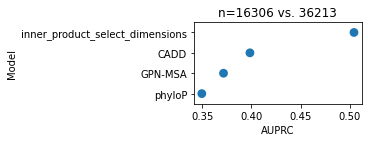

In [20]:
plt.figure(figsize=(3,1.5))
sns.pointplot(
    data=results.sort_values("AUPRC", ascending=False),
    y="Model",
    x="AUPRC",
    join=False,
)
plt.title(subtitle);

In [14]:
#plt.figure(figsize=(3,3))
#plt.plot(results.AUPRC.values)
#plt.xlabel("Number top features to add")
#plt.ylabel("AUPRC")
#sns.despine();